We have a product called Drug 390 for breast cancer treatment and our team is interested in understanding 
how long patients are on treatment when they are taking our product compared to the generic. For additional 
context, breast cancer patients can fall into four categories based on their HER2 status (0 or 1) or their 
Hormone Receptor (HR) status (0 or 1) so we are also interested in understanding how the cancer category 
might impact length of treatment as well. 

In [364]:
#libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

In [365]:
# dataframes 

# Contains Flags and Receptor Markers - 37 Rows 5 Columns
d390 = pd.read_csv('drug390.csv')
# Contains Treatment Dates for each Patient ID - 339 Rows 4 Columns
adm_main = pd.read_csv('pat_drug_admin_date.csv')

In [366]:
#create copies of dataframes to work with 
admin_date = adm_main.copy()
markers_390 = d390.copy() 

In [367]:
admin_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Patient_ID       339 non-null    int64 
 1   Drug_admin_date  339 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [368]:
markers_390.head(5)

,Patient_ID,drug_390_admin_flag,ER_positive,PR_positive,HER2_positive
0,2038,1,1,1,0
1,2120,0,1,0,1
2,2175,0,0,0,0
3,2407,0,0,1,0
4,2425,1,0,0,0


In [369]:
markers_390.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Patient_ID           37 non-null     int64
 1   drug_390_admin_flag  37 non-null     int64
 2   ER_positive          37 non-null     int64
 3   PR_positive          37 non-null     int64
 4   HER2_positive        37 non-null     int64
dtypes: int64(5)
memory usage: 1.6 KB


    a. Describe how you would compute the length of treatment for each patient --
    
The length of treatment is obtained by aggregating each Patient_ID to filter out just for uniques and then take the resulting data structure and subtract the min date (start of treatment) from the max date (current treatment date). 
<br> The data must be prepared however as the date column is actually a 

In [370]:
# sort the dates by most recent to oldest and replaces back to original dataframe
admin_date.sort_values(by=['Patient_ID', 'Drug_admin_date'], inplace=True)

# converts the string object type of the Drug_admin_date column and converts it into a datetime object with a placeholder value for the year of 1900 across the dataset
admin_date['Date'] =  pd.to_datetime(admin_date['Drug_admin_date'], format='%d-%b')
admin_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 1 to 324
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Patient_ID       339 non-null    int64         
 1   Drug_admin_date  339 non-null    object        
 2   Date             339 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.6+ KB


In [371]:
# Option 1 of Calculating Treatment Length
start_q1o1 = time.time()
def trx_length(x):
    """
    This function will iterate over each row in the dataframe and verify the ID in the list pat_id is the one being reviewed and then take the difference between these values.
    """
    pat_id = list(admin_date['Patient_ID'].unique())
    for item in pat_id:
        max_date = admin_date[admin_date['Patient_ID'] == item]['Date'].max()
        min_date = admin_date[admin_date['Patient_ID'] == item]['Date'].min()
        trx_length = max_date - min_date
        if x == item:
            return trx_length

admin_date['Trx_Length'] = admin_date['Patient_ID'].apply(lambda x: trx_length(x))
end_q1o1 = time.time()

# Option 2 of Calculating Treatment Length 
start_q1o2 = time.time()
""" 
The data is grouped by the Patient_Id and then the max and min are subtracted to leave a series object which we have to reset the index on and then do a merge with the original dataframe using the 
Patient_ID column as the 'primary key'
"""
calc_dates = (admin_date.groupby('Patient_ID')['Date'].max() - admin_date.groupby('Patient_ID')['Date'].min()).reset_index()
# merge this new group by on the index to the main dataframe
admin_date = admin_date.merge(calc_dates, left_on='Patient_ID',right_on='Patient_ID', suffixes=('','_Goupby'))
end_q1o2 = time.time()

# Option 3 - create two columns identifying the start and end date for each Patient_ID and then do series arthmetic assigning to a new column called 'Date_Difference'
start_q1o3 = time.time()
def trx_end(x):
    pat_id = list(admin_date['Patient_ID'].unique())
    for item in pat_id:
        max_date = admin_date[admin_date['Patient_ID'] == item]['Date'].max()
        if x == item:
            return max_date

def trx_start(x):
    pat_id = list(admin_date['Patient_ID'].unique())
    for item in pat_id:
        min_date = admin_date[admin_date['Patient_ID'] == item]['Date'].min()
        if x == item:
            return min_date
        
admin_date['Trx_End'] = admin_date['Patient_ID'].apply(lambda x:trx_end(x))
admin_date['Trx_Start'] = admin_date['Patient_ID'].apply(lambda x:trx_start(x))

# series arithmetic to create new column
admin_date['Date_Difference'] = admin_date['Trx_End'] - admin_date['Trx_Start']
end_q1o3 = time.time()

print('Option 1 Run Time: ', end_q1o1 - start_q1o1)
print('Option 2 Run Time: ', end_q1o2 - start_q1o2)
print('Option 3 Run Time: ', end_q1o3 - start_q1o3)


Option 1 Run Time:  10.100568771362305
Option 2 Run Time:  0.005798816680908203
Option 3 Run Time:  10.88792896270752


b. Describe or show how you might go about comparing the length of treatment by drug 390 vs. the generic 
(i.e. through a visualization, descriptive analytics, statistical tests, or machine learning)  

In [372]:
unique_patientid = admin_date.drop_duplicates(subset='Patient_ID').sort_values(by='Trx_Length',ascending=False)[['Patient_ID', 'Trx_Length']]
unique_patientid['Trx_Length'] = unique_patientid['Trx_Length'].dt.days

In [373]:
markers_dates = markers_390.merge(unique_patientid, left_on='Patient_ID', right_on='Patient_ID').sort_values(by='Trx_Length', ascending=False)
generic = markers_dates[markers_390['drug_390_admin_flag']==0] 
on_390 = markers_dates[markers_390['drug_390_admin_flag']==1] 


/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


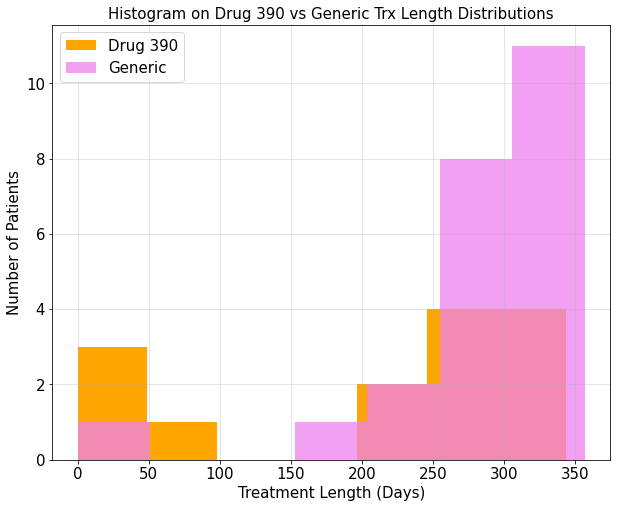

In [374]:
plt.figure(figsize=(10,8))
plt.tick_params(labelsize=15)


plt.hist(on_390['Trx_Length'], bins=7, color='orange', label='Drug 390')
plt.hist(generic['Trx_Length'], bins=7, color='violet', alpha=0.75, label='Generic')
plt.xlabel('Treatment Length (Days)', fontsize=15)
plt.title('Histogram on Drug 390 vs Generic Trx Length Distributions', fontsize=15)

plt.ylabel('Number of Patients', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=.4)


No handles with labels found to put in legend.


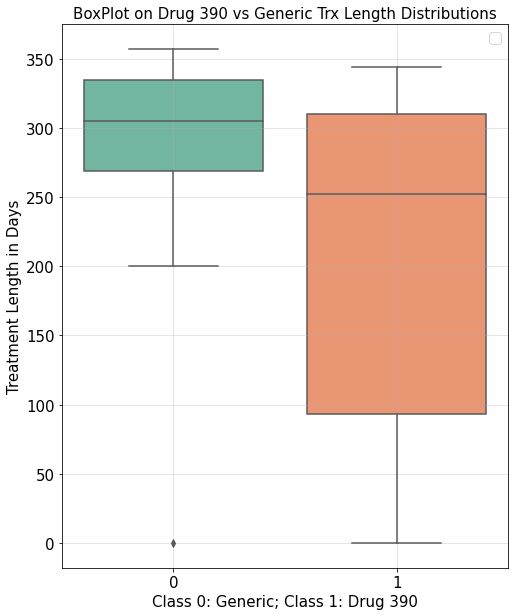

In [375]:
plt.figure(figsize=(8,10))
plt.tick_params(labelsize=15)


sns.boxplot(x='drug_390_admin_flag',y='Trx_Length',data=markers_dates, palette='Set2')
plt.xlabel('Class 0: Generic; Class 1: Drug 390', fontsize=15)
plt.title('BoxPlot on Drug 390 vs Generic Trx Length Distributions', fontsize=15)

plt.ylabel('Treatment Length in Days', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=.4)


The histogram shows us that the data is not normally distrubuted for both drug datasets. This shows an assymetric pattern in the data which would make it difficult to calculate confidence intervals and see how representative these numbers are of an actual population's results with our two drugs. From the sample mean and standard deviation we collect we can create random sampling simulations with different sample sizes to see how accurate our estimation can be. 

Upon first glance you notice there is an outlier in the 0 label, 'not on drug 390', for column drug_390_admin_flag. Looking at the boxplot we see we have zeros as well in marker 1, 'on drug 390', and these are affecting the data. These must also be corrected for. 

When running a minimum statistic for our data it shows 0 as a value which is actually an outlier and can be dropped if the dataset was larger. We could say this patient never received treatment and is not valid in the sample. However, since samples are limited on our dataset we can fill this specific instance with the median. The median is used as there is quite a variance in our values. 


In [376]:
def stats_comparison_95_confident(dataframe):
    # p_values for t test with a 95% confidence interval
    ninetyfive_confidence_pvals = {1:12.71, 2:4.303, 3:3.182, 4:2.776, 5:2.571, 6:2.447, 7:2.365, 8:2.306, 9:2.262, 10:2.228, 11:2.201, 12:2.179, 13:2.16, 14:2.145, 15:2.131,
                                   16:2.12, 17:2.11, 18:2.101, 19:2.093, 20:2.086, 21:2.086, 22:2.086, 23:2.086, 24:2.086, 25:2.086, 26:2.086, 27:2.086, 28:2.086, 29:2.086}
    # remove 0 treatment day patients
    def replace_zeros(y):
        if y == 0:
            return np.median(dataframe['Trx_Length'])
        else:
            return y
    dataframe['Trx_Length'] = dataframe['Trx_Length'].apply(lambda y: replace_zeros(y))
    # sample
    sample_mean = dataframe['Trx_Length'].mean()
    sample_std = dataframe['Trx_Length'].std()
    sample_size = dataframe['Trx_Length'].shape[0]
    t_top = sample_mean + (ninetyfive_confidence_pvals[sample_size-1] * (sample_std/(np.sqrt(sample_size))))
    t_bottom = sample_mean - (ninetyfive_confidence_pvals[sample_size-1] * (sample_std/(np.sqrt(sample_size))))
    # sample sizes
    a_sizes = [10000, 100000, 1000000]
    # create random sampling 
    np.random.seed(42)
    for a in a_sizes:
        sim1 = np.random.normal(sample_mean, sample_std, a)
        # calculate 95% confidence interval
        z_score_95_bottom = sim1.mean() - 1.960 * (sim1.std() / (np.sqrt(a)))
        z_score_95_top = sim1.mean() + 1.960 * (sim1.std() / (np.sqrt(a)))
        z_95 = (z_score_95_bottom, z_score_95_top)


        print('Simulation of {aa} size mean:'.format(aa=a), sim1.mean())
        print('95% Confidence Interval of {ab} Sample Size'.format(ab=z_95))
        print('\n')    
    print('Sample Mean:', sample_mean, 'Sample Std:', sample_std, 'Sample Size:', sample_size, 'Degrees of Freedom:', sample_size-1)
    print('95% Confidence Less Than 30 Samples Using t-score:', t_bottom, t_top )

    return dataframe

In [377]:
generic_only = stats_comparison_95_confident(generic)

/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Simulation of 10000 size mean: 300.2538767872502
95% Confidence Interval of (299.38884686270467, 301.1189067117957) Sample Size


Simulation of 100000 size mean: 300.4495270709093
95% Confidence Interval of (300.1769043161912, 300.7221498256274) Sample Size


Simulation of 1000000 size mean: 300.2722575048093
95% Confidence Interval of (300.1859777996804, 300.3585372099382) Sample Size


Sample Mean: 300.3478260869565 Sample Std: 43.98409701828417 Sample Size: 23 Degrees of Freedom: 22
95% Confidence Less Than 30 Samples Using t-score: 281.21645628504905 319.47919588886396


In [378]:
on_drug_390 = stats_comparison_95_confident(on_390)

Simulation of 10000 size mean: 241.9391750848481
95% Confidence Interval of (240.06379042714826, 243.81455974254794) Sample Size


Simulation of 100000 size mean: 242.3633448503526
95% Confidence Interval of (241.77229878705393, 242.95439091365128) Sample Size


Simulation of 1000000 size mean: 241.97902447586867
95% Confidence Interval of (241.79197009696426, 242.16607885477308) Sample Size


Sample Mean: 242.14285714285714 Sample Std: 95.35751121466492 Sample Size: 14 Degrees of Freedom: 13
95% Confidence Less Than 30 Samples Using t-score: 187.09446469737307 297.1912495883412


/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Simulations were run which ranged from 10K samples to 1M samples based on our sample means and standard deviations for both markers. 

Using t-scores due to low number of samples we can be 95% confident our sample means are representative of the population means for each drug marker group, on 390 or not. To verify three simulations were run using our specific sample means and standard deviations. Each subsequent simulation was also confidence tested and provided confirmation the mean was representative of the true population with 95% confidence. 

From this we can continue working with our values for the 'Trx_Length' columns as they are close representations of the true values observed if given to larger groups. 



In [379]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

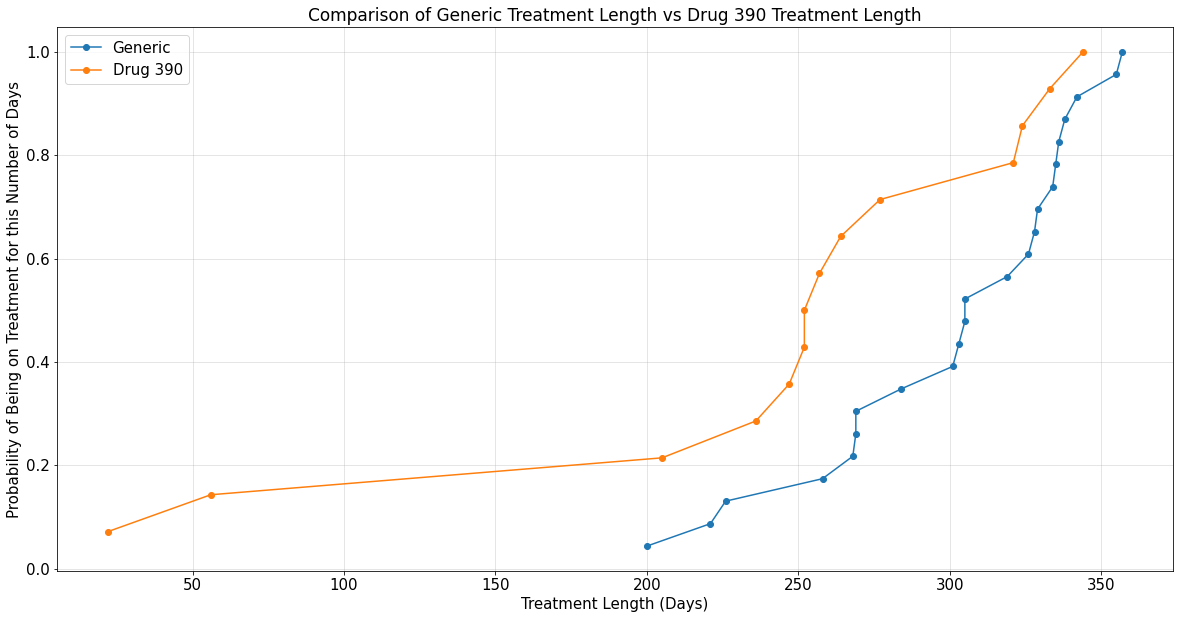

In [380]:
x_gen, y_gen = ecdf(generic['Trx_Length'])
x_390, y_390 = ecdf(on_drug_390['Trx_Length'])

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=15)

gen_plot = plt.plot(x_gen,y_gen, marker='o', label='Generic')
plot_390 = plt.plot(x_390, y_390, marker='o', label='Drug 390')
m_gen, b_gen = np.polyfit(x_gen, y_gen, 1)
m_390, b_390 = np.polyfit(x_390, y_390, 1)
plt.title('Comparison of Generic Treatment Length vs Drug 390 Treatment Length',fontsize=17)

# gen_reg_line = plt.plot(x_gen, m_gen*x_gen + b_gen, label='Generic')
# reg_line_390 = plt.plot(x_390, m_390*x_390 + b_390, label='Drug 390')

plt.xlabel('Treatment Length (Days)', fontsize=15)
plt.ylabel('Probability of Being on Treatment for this Number of Days', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=.4)

The data shows that a patient on the generic has a higher probability, based on the ECDF scale, to be on treatment for longer than if they were on our 'drug 390.' 

Using this chart one could estimate a new patient with similar health conditions as these used in the sample would demonstrate similar behaviors. This can be backed up by our confidence interval calculations further up on the document. 

In [381]:
# creates new column for Hormone Receptor Status with Generics
generic['HR_status'] = 0
generic.loc[(generic['ER_positive'] ==1) | (generic['PR_positive'] ==1), 'HR_status'] = 1

# creates new column for Hormone Receptor Status with D390
on_390['HR_status'] = 0
on_390.loc[(on_390['ER_positive'] ==1) | (on_390['PR_positive'] ==1), 'HR_status'] = 1

# merges generic and 390 and then creates class labels for the four types of tumor categories
hr_status_set = generic.append(on_390, ignore_index=True)
hr_status_set['class_category'] = 0
 
# HER2_positive

# Generic HR
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==1), 'class_category'] = 0
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==1), 'class_name'] = 'Generic HER2+/HR+'
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==0), 'class_category'] = 1
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==0), 'class_name'] = 'Generic HER2+/HR-'
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==1), 'class_category'] = 2
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==1), 'class_name'] = 'Generic HER2-/HR+'
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==0), 'class_category'] = 3
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==0) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==0), 'class_name'] = 'Generic HER2-/HR-'

# Drug 390
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==1), 'class_category'] = 4
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==1), 'class_name'] = 'D390 HER2+/HR+'
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==0), 'class_category'] = 5
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==1) & (hr_status_set['HR_status'] ==0), 'class_name'] = 'D390 HER2+/HR-'
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==1), 'class_category'] = 6
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==1), 'class_name'] = 'D390 HER2-/HR+'
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==0), 'class_category'] = 7
hr_status_set.loc[(hr_status_set['drug_390_admin_flag'] ==1) & (hr_status_set['HER2_positive'] ==0) & (hr_status_set['HR_status'] ==0), 'class_name'] = 'D390 HER2-/HR-'

/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/oldvasegreenbird/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [382]:
hr_status_set['class_name'].value_counts()

Generic HER2+/HR+    10
Generic HER2-/HR+     8
D390 HER2-/HR+        6
Generic HER2-/HR-     5
D390 HER2+/HR+        4
D390 HER2-/HR-        3
D390 HER2+/HR-        1
Name: class_name, dtype: int64

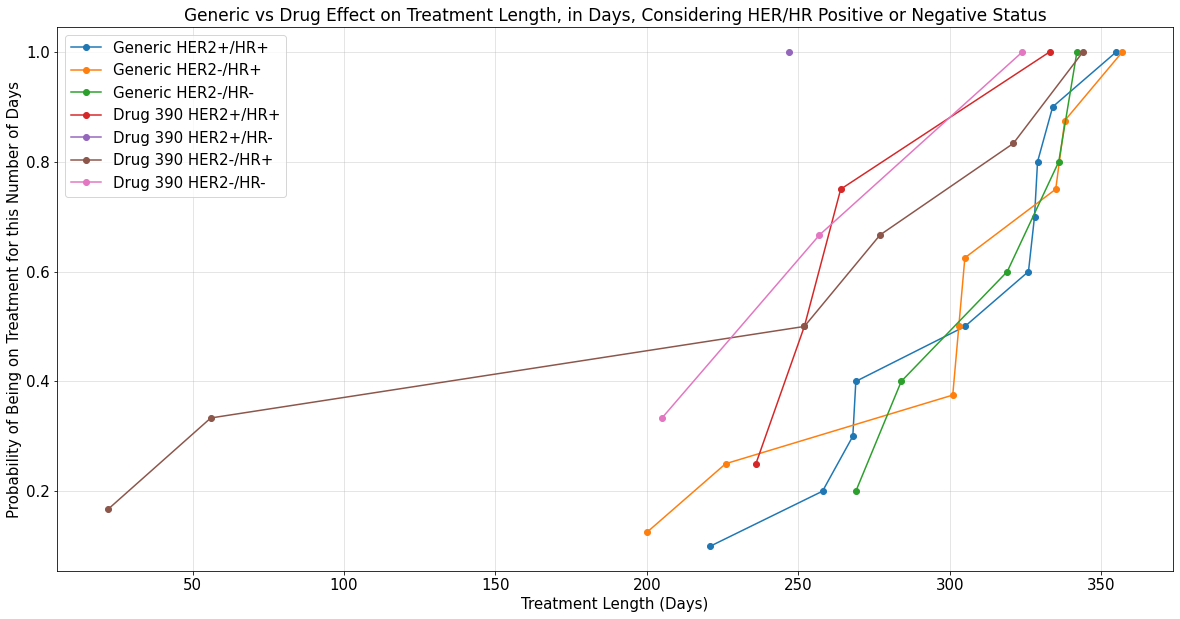

In [383]:

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=15)
# Generic and HER2+/HR+
x0,y0 = ecdf(hr_status_set[hr_status_set['class_category'] == 0]['Trx_Length'])
cat0_plot = plt.plot(x0,y0, marker='o', label='Generic HER2+/HR+')
# Generic HER2+ HR - 0 values
# x1,y1 = ecdf(hr_status_set[hr_status_set['class_category'] == 1]['Trx_Length']) 
# cat1_plot = plt.plot(x1,y1, marker='o', label='Generic HER2+/HR-')
# Generic and HER2-/HR+
x2,y2 = ecdf(hr_status_set[hr_status_set['class_category'] == 2]['Trx_Length']) 
cat2_plot = plt.plot(x2,y2, marker='o', label='Generic HER2-/HR+')
# Generic and HER2-/HR-
x3,y3 = ecdf(hr_status_set[hr_status_set['class_category'] == 3]['Trx_Length']) 
cat3_plot = plt.plot(x3,y3, marker='o', label='Generic HER2-/HR-')
# D390 and HER2+/HR+
x4,y4 = ecdf(hr_status_set[hr_status_set['class_category'] == 4]['Trx_Length']) 
cat4_plot = plt.plot(x4,y4, marker='o', label='Drug 390 HER2+/HR+')
# D390 and HER2+/HR-
x5,y5 = ecdf(hr_status_set[hr_status_set['class_category'] == 5]['Trx_Length']) 
cat5_plot = plt.plot(x5,y5, marker='o', label='Drug 390 HER2+/HR-')
# D390 and HER2-/HR+
x6,y6 = ecdf(hr_status_set[hr_status_set['class_category'] == 6]['Trx_Length']) 
cat6_plot = plt.plot(x6,y6, marker='o', label='Drug 390 HER2-/HR+')
# D390 and HER2-/HR-
x7,y7 = ecdf(hr_status_set[hr_status_set['class_category'] == 7]['Trx_Length']) 
cat7_plot = plt.plot(x7,y7, marker='o', label='Drug 390 HER2-/HR-')


plt.title('Generic vs Drug Effect on Treatment Length, in Days, Considering HER/HR Positive or Negative Status',fontsize=17)
plt.xlabel('Treatment Length (Days)', fontsize=15)
plt.ylabel('Probability of Being on Treatment for this Number of Days', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=.4)
plt.show()




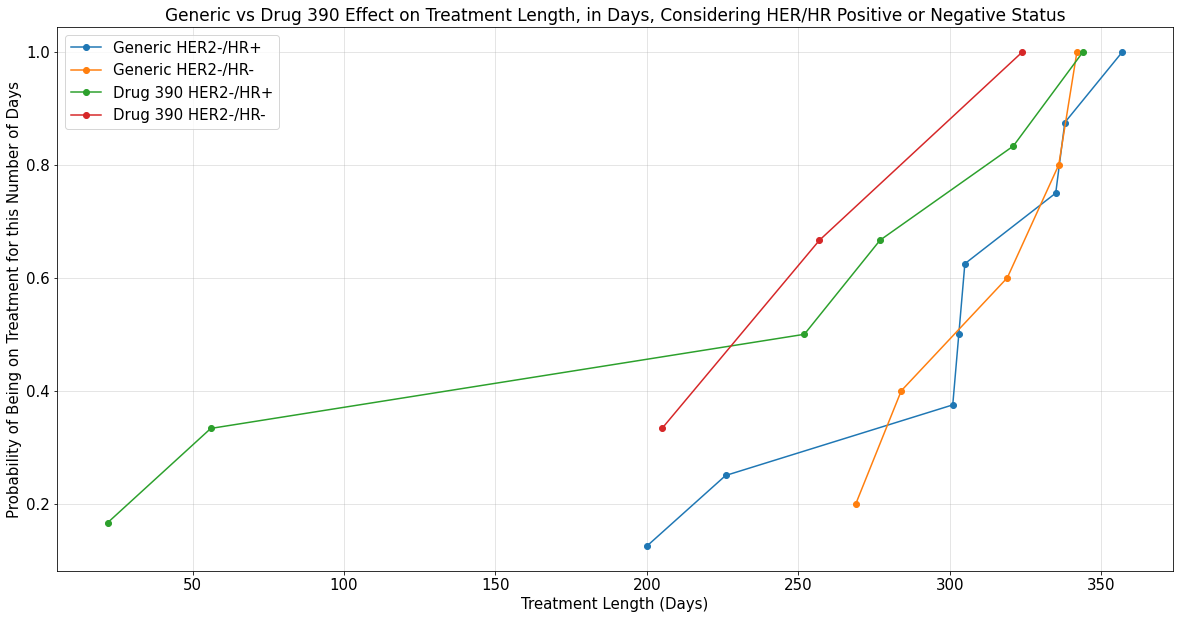

In [384]:

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=15)

# Generic and HER2-/HR+
x2,y2 = ecdf(hr_status_set[hr_status_set['class_category'] == 2]['Trx_Length']) 
cat2_plot = plt.plot(x2,y2, marker='o', label='Generic HER2-/HR+')
# Generic and HER2-/HR-
x3,y3 = ecdf(hr_status_set[hr_status_set['class_category'] == 3]['Trx_Length']) 
cat3_plot = plt.plot(x3,y3, marker='o', label='Generic HER2-/HR-')

# D390 and HER2-/HR+
x6,y6 = ecdf(hr_status_set[hr_status_set['class_category'] == 6]['Trx_Length']) 
cat6_plot = plt.plot(x6,y6, marker='o', label='Drug 390 HER2-/HR+')
# D390 and HER2-/HR-
x7,y7 = ecdf(hr_status_set[hr_status_set['class_category'] == 7]['Trx_Length']) 
cat7_plot = plt.plot(x7,y7, marker='o', label='Drug 390 HER2-/HR-')


plt.title('Generic vs Drug 390 Effect on Treatment Length, in Days, Considering HER/HR Positive or Negative Status',fontsize=17)
plt.xlabel('Treatment Length (Days)', fontsize=15)
plt.ylabel('Probability of Being on Treatment for this Number of Days', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=.4)
plt.show()




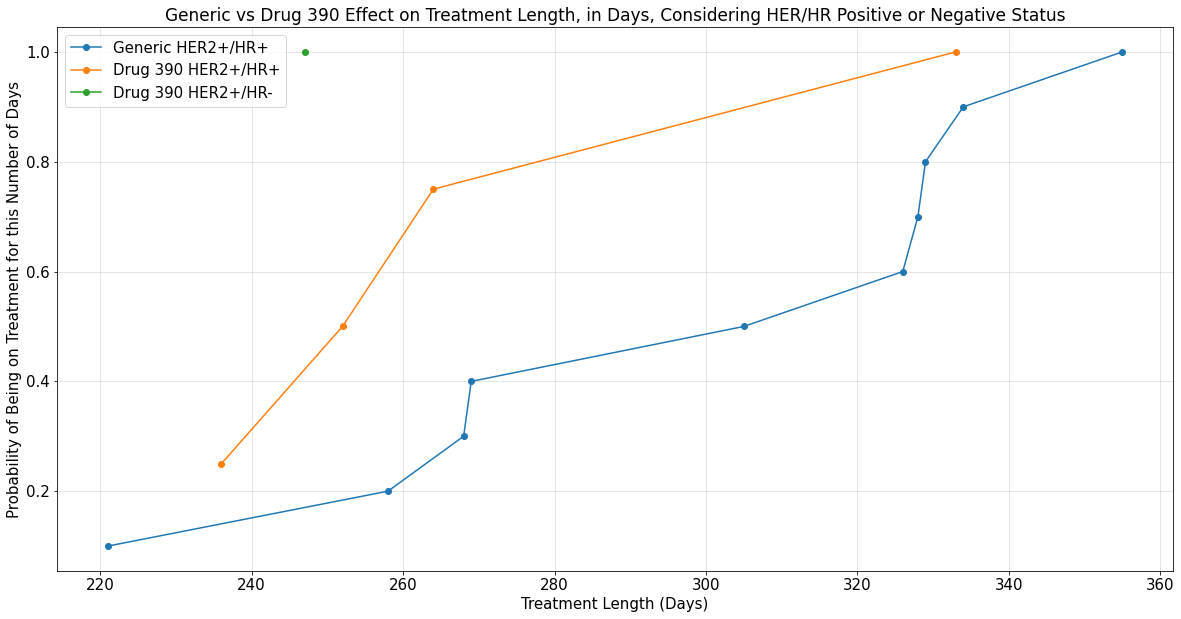

In [385]:

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=15)
# Generic and HER2+/HR+
x0,y0 = ecdf(hr_status_set[hr_status_set['class_category'] == 0]['Trx_Length'])
cat0_plot = plt.plot(x0,y0, marker='o', label='Generic HER2+/HR+')
# # Generic HER2+ HR -
# x1,y1 = ecdf(hr_status_set[hr_status_set['class_category'] == 1]['Trx_Length']) 
# cat1_plot = plt.plot(x1,y1, marker='o', label='Generic HER2+/HR-')

# D390 and HER2+/HR+
x4,y4 = ecdf(hr_status_set[hr_status_set['class_category'] == 4]['Trx_Length']) 
cat4_plot = plt.plot(x4,y4, marker='o', label='Drug 390 HER2+/HR+')
# D390 and HER2+/HR-
x5,y5 = ecdf(hr_status_set[hr_status_set['class_category'] == 5]['Trx_Length']) 
cat5_plot = plt.plot(x5,y5, marker='o', label='Drug 390 HER2+/HR-')



plt.title('Generic vs Drug 390 Effect on Treatment Length, in Days, Considering HER/HR Positive or Negative Status',fontsize=17)
plt.xlabel('Treatment Length (Days)', fontsize=15)
plt.ylabel('Probability of Being on Treatment for this Number of Days', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=.4)
plt.show()




In [386]:

def knn_classifier( X, y):
    startf = time.time()

    neighbors_vals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    knn_train_scores = []
    knn_test_scores = []
    cv_scores_means = []
    for i in neighbors_vals:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
        knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)

#       knn.fit(X_train, y_train)
            
        train_score = knn.score(X_train, y_train)
        knn_train_scores.append(train_score)
            
        test_score = knn.score(X_test,y_test)
        knn_test_scores.append(test_score)
            
        cv_results = cross_val_score(knn, X, y, cv=5)
        cv_means = cv_results.mean()
        cv_scores_means.append(cv_means)
            
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=15)
    plt.plot(neighbors_vals, knn_train_scores, marker='o',markersize=15, label='Train Scores')
    plt.plot(neighbors_vals, knn_test_scores, marker='h',markersize=15, label='Test Scores')
    plt.plot(neighbors_vals, cv_scores_means, marker='v',markersize=15, label='Cross Validation Mean', alpha=0.5)
    plt.title('KNN Classifier Accuracy Scores & 5-Fold Validation Scores Classifying: On Drug 390 vs Generic', fontsize=18)
    plt.xlabel('Neighbors Parameter', fontsize=15)
    plt.ylabel('Test Score', fontsize=15)
    plt.legend(fontsize=17)
    plt.grid(True, alpha=.4)
    plt.show()
    endf = time.time()
    print('Comp Time:', round(endf - startf, 3))
        
def log_classifier(X, y):
    startf = time.time()       
    alphas_log = [0.01, 0.1, 1, 10, 20, 30, 40, 50]
    log_test_list = []
    cv_scores_means = []

    for al in alphas_log:            
        logreg = LogisticRegression(C=al).fit(X, y)
        log_test_score = logreg.score(X, y)
        log_test_list.append(log_test_score)
            
            
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=15)
    plt.plot(alphas_log, log_test_list, marker='h', label='Scores', markersize=15)
    plt.title('Logistic Regressor Classifying Accuracy Scores on Drug 390 v Generic', fontsize=18)
    plt.xlabel('Variable C(alpha) Parameter Range: 0.01 to 50', fontsize=15)
    plt.ylabel('Test Score', fontsize=15)
    plt.legend(fontsize=17)
    plt.grid(True, alpha=.4)
    plt.show()
    endf = time.time()
    print('Comp Time:', round(endf - startf, 3))
        
        
# attempts to cut a divider across a 3-dimensional space however our data does not do well with this model since data is sparse and heavily categorical         
def linear_svc_classifier(X, y):
    startf = time.time()

    alphas_log = [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600]
    cv_scores_means = []

    linear_SVC_train_list = []
    linear_SVC_test_list = []
    for al in alphas_log:    
        linear_SVC = LinearSVC(C=al).fit(X, y)
        linear_SVC_score = linear_SVC.score(X, y)
        linear_SVC = linear_SVC.score(X, y)
            
        
    plt.figure(figsize=(20,10))
    plt.title(' LinearSVC Classifying Accuracy Score on Drug 390 v Generic', fontsize=18)
    plt.xlabel('Alpha Parameter', fontsize=15)
    plt.ylabel('Test Score', fontsize=15)
    plt.plot(alphas_log, alphas_log, marker='h',markersize=15, label='Scores')
    plt.legend(fontsize=17)
    plt.grid(True, alpha=.4)
    plt.show()
    endf = time.time()
    print('Comp Time:', round(endf - startf, 3))
        

def gaussian_naive_bayes(X, y):
    gnb_train_scores = []
    gnb_test_scores = []
    cv_scores_means = []
    startf = time.time()
    sizer = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    for sz in sizer:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = sz, random_state=42, stratify=y)
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        
        train_score = gnb.score(X_train, y_train)
        gnb_train_scores.append(train_score)
            
        test_score = gnb.score(X_test,y_test)
        gnb_test_scores.append(test_score)
            
        cv_results = cross_val_score(gnb, X, y, cv=5)
        cv_means = cv_results.mean()
        cv_scores_means.append(cv_means)
            
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=15)
    plt.plot(sizer, gnb_train_scores, marker='o',markersize=15, label='Train Scores')
    plt.plot(sizer, gnb_test_scores, marker='h',markersize=15, label='Test Scores')
    plt.plot(sizer, cv_scores_means, marker='v',markersize=15, label='Cross Validation Mean', alpha=0.5)
    plt.title('Gaussian Naive Bayes Classifier Accuracy Score Values Based on Test Sizes from \'TTS\'', fontsize=18)
    plt.xlabel('Test Size Parameter from \'TTS\'', fontsize=15)
    plt.ylabel('Score', fontsize=15)
    plt.legend(fontsize=17)
    plt.grid(True, alpha=.4)
    plt.show()
    endf = time.time()
    print('Comp Time:', round(endf - startf, 3))
    
def bernoulli_naive_bayes(X, y):
    bern_train_scores = []
    bern_test_scores = []
    cv_scores_means = []
    startf = time.time()
    sizer = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    for sz in sizer:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = sz, random_state=42, stratify=y)
        bern = BernoulliNB()
        bern.fit(X_train, y_train)
        
        train_score = bern.score(X_train, y_train)
        bern_train_scores.append(train_score)
            
        test_score = bern.score(X_test,y_test)
        bern_test_scores.append(test_score)
            
        cv_results = cross_val_score(bern, X, y, cv=5)
        cv_means = cv_results.mean()
        cv_scores_means.append(cv_means)
            
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=15)
    plt.plot(sizer, bern_train_scores, marker='o',markersize=15, label='Train Scores')
    plt.plot(sizer, bern_test_scores, marker='h',markersize=15, label='Test Scores')
    plt.plot(sizer, cv_scores_means, marker='v',markersize=15, label='Cross Validation Mean', alpha=0.5)
    plt.title('Bernoulli Naive Bayes Classifier Accuracy Score Values Based on Test Sizes from \'TTS\'', fontsize=18)
    plt.xlabel('Test Size Parameter from \'TTS\'', fontsize=15)
    plt.ylabel('Score', fontsize=15)
    plt.legend(fontsize=17)
    plt.grid(True, alpha=.4)
    plt.show()
    endf = time.time()
    print('Comp Time:', round(endf - startf, 3))
    

In [387]:
features = hr_status_set[['ER_positive', 'PR_positive', 'HER2_positive', 'Trx_Length', 'HR_status']]
target_col = hr_status_set['drug_390_admin_flag']


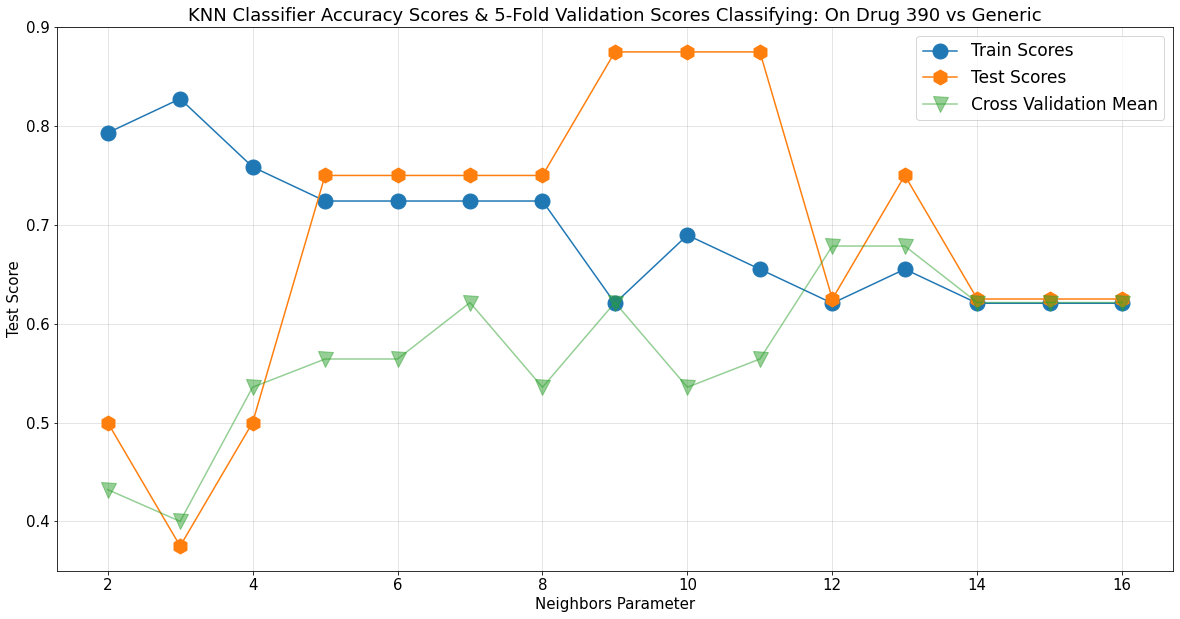

Comp Time: 0.648


In [388]:
knn_modeler = knn_classifier(features, target_col)

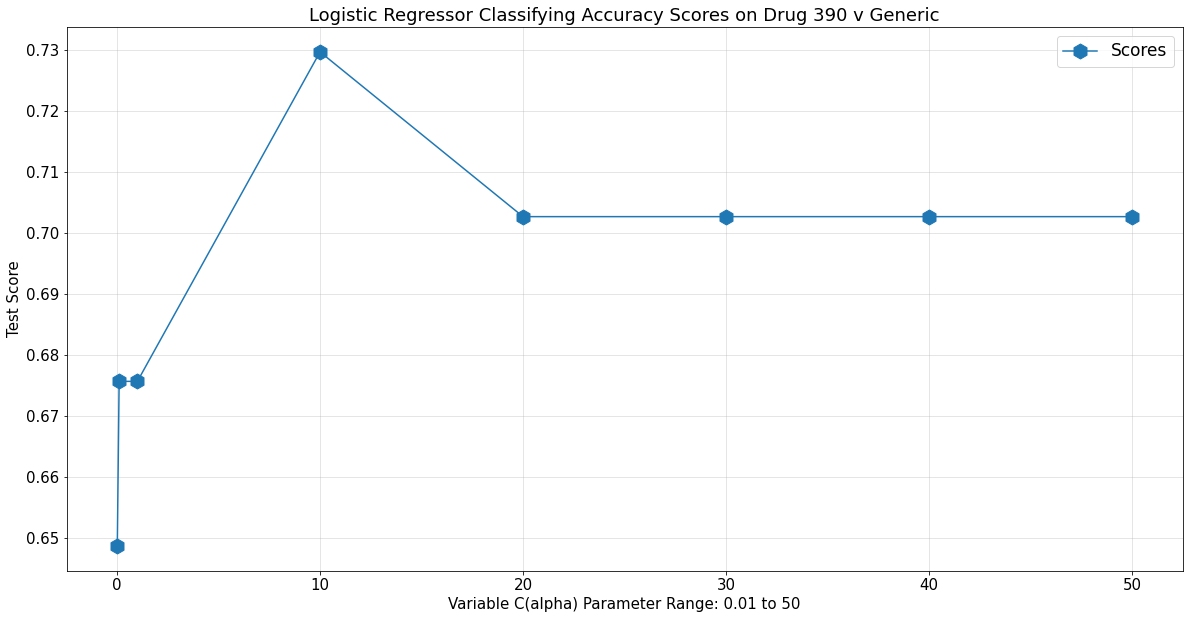

Comp Time: 0.357


In [389]:
logreg_modeler = log_classifier(features, target_col)

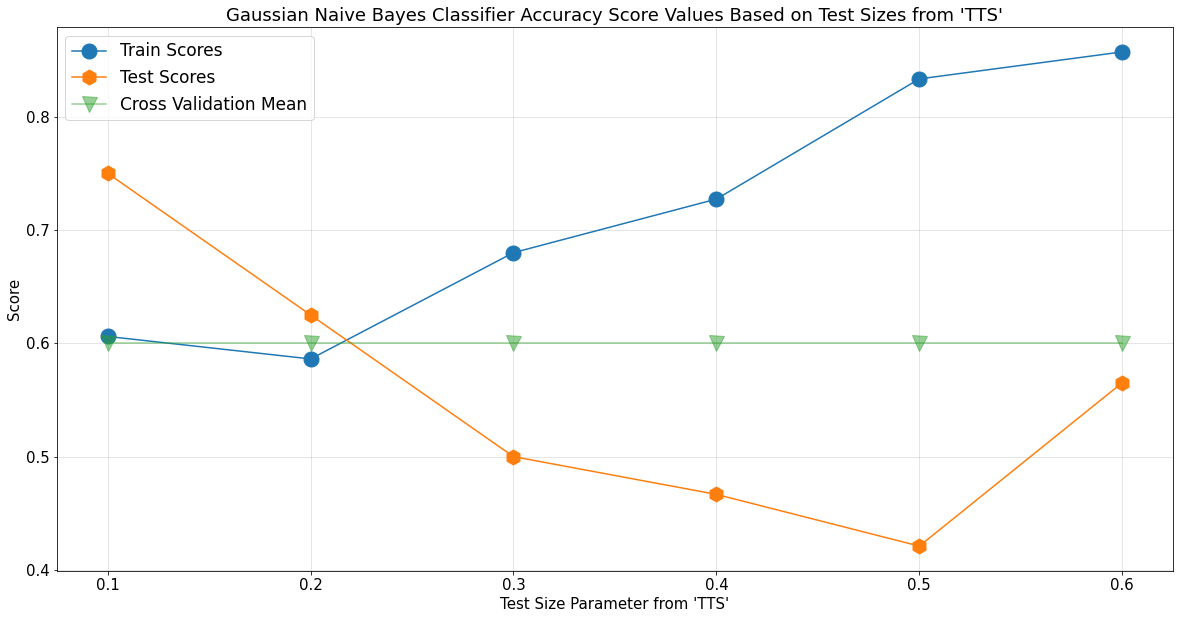

Comp Time: 0.383


In [390]:
gnb_modeler = gaussian_naive_bayes(features, target_col)

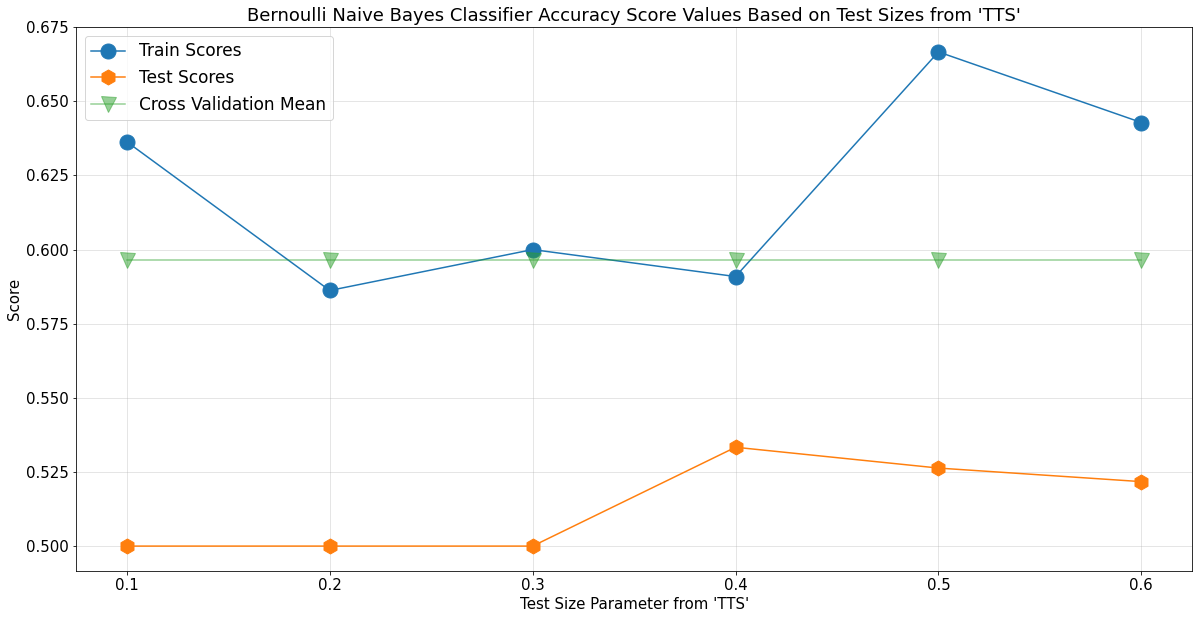

Comp Time: 0.4


In [391]:
bernoulli_naive_bayes(features, target_col)

In [392]:
hr_status_set.to_csv('hormone_receptor_status_corrected.csv')